### A MCMC example for a Bayesian multiple logistic regression

This algorithm samples from the **posterior distribution** of the regression coefficients $\beta$ in a Bayesian logistic regression model with a flat (uniform) prior.

---

#### **Model Setup**

- **Likelihood:**
  For binary data $y_i \in \{0, 1\}$, and predictors $X_i$, the model is:
  $$
  y_i \sim \mathrm{Bernoulli}(p_i), \quad p_i = \frac{1}{1 + \exp(-\eta_i)}, \quad \eta_i = X_i \beta
  $$
  The likelihood for all data is:
  $$
  p(\mathbf{y} | \beta, X) = \prod_{i=1}^n p_i^{y_i} (1 - p_i)^{1-y_i}
  $$

- **Log-Likelihood (as implemented in `logit_loglik`):**
  $$
  \log p(\mathbf{y} | \beta, X) = \sum_{i=1}^n y_i \log(p_i) + (1 - y_i) \log(1 - p_i)
  $$
  In code:
  - $\log(p_i) = \log\left(\frac{1}{1 + \exp(-\eta_i)}\right)$
  - $\log(1 - p_i) = \log\left(\frac{1}{1 + \exp(\eta_i)}\right)$

- **Prior:**
  - **Flat prior:** $p(\beta) \propto 1$
  - The posterior is proportional to the likelihood alone.

- **Posterior:**
  $$
  p(\beta | \mathbf{y}, X) \propto p(\mathbf{y} | \beta, X)
  $$

---

#### **Algorithm Steps and Equations**

1. **Proposal Step:**
   - Propose $\beta^* \sim \mathcal{N}(\beta^{(t-1)},\, \delta\,V)$ where $V$ is the estimated covariance from the frequentist fit.

2. **Acceptance Ratio:**
   - With a flat prior, the Metropolis-Hastings acceptance ratio simplifies to:
     $$
     R = \frac{p(\mathbf{y} | \beta^*, X)}{p(\mathbf{y} | \beta^{(t-1)}, X)}
     $$
     The code works on the log scale for stability:
     $$
     \log R = \log p(\mathbf{y} | \beta^*, X) - \log p(\mathbf{y} | \beta^{(t-1)}, X)
     $$
   - Accept $\beta^*$ with probability $\min(1, R)$.

3. **Sampling:**
   - If accepted, set $\beta^{(t)} = \beta^*$. Otherwise, set $\beta^{(t)} = \beta^{(t-1)}$.
   - Repeat for `nIter` iterations, discarding the first `nBurnIn` as burn-in.

---

In [3]:
import numpy as np
from scipy.stats import multivariate_normal, gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

In [4]:
def logit_loglik(beta, y, X):
    """
    Computes log-likelihood for a logit model.
    beta: shape (p,) or (n,p)
    y: binary response, shape (n,)
    X: design matrix, shape (n,p)
    Returns: log-likelihood
    """
    beta = np.atleast_2d(beta)
    n = beta.shape[0]
    pll = np.zeros(n)
    for i in range(n):
        eta = X @ beta[i]
        lf1 = np.log(1 / (1 + np.exp(-eta)))
        lf2 = np.log(1 / (1 + np.exp(eta)))
        pll[i] = np.sum(y * lf1 + (1 - y) * lf2)
    return pll if n > 1 else pll[0]

def MHflatLogit(nIter, nBurnIn, y, X, delta, plot=True):
    """
    Metropolis-Hastings for logistic regression with flat prior.
    """
    if nIter <= nBurnIn:
        raise ValueError("Number of warm-up iterations must be smaller than total iterations.")

    n, p = X.shape

    # Frequentist initialization using statsmodels
    import statsmodels.api as sm
    model = sm.Logit(y, X)
    result = model.fit(disp=0)
    beta_start = result.params
    variance = result.cov_params()

    beta = np.zeros((nIter, p))
    beta[0] = beta_start

    for i in range(1, nIter):
        beta_hat = multivariate_normal.rvs(mean=beta[i-1], cov=delta * variance)
        # Log acceptance ratio
        logR = logit_loglik(beta_hat, y, X) - logit_loglik(beta[i-1], y, X)
        if np.random.uniform() <= np.exp(logR):
            beta[i] = beta_hat
        else:
            beta[i] = beta[i-1]

    # Remove warm-up iterations
    beta_post = beta[nBurnIn:]

    # Plotting
    if plot:
        fig, axs = plt.subplots(2, p, figsize=(4*p, 8))
        # Traceplots
        for j in range(p):
            axs[0, j].plot(beta_post[:, j])
            axs[0, j].set_title(f'Traceplot: beta{j}' if j > 0 else 'Traceplot: alpha')
        # Density plots
        for j in range(p):
            axs[1, j].hist(beta_post[:, j], bins=50, density=True, alpha=0.6)
            kde = gaussian_kde(beta_post[:, j])
            x_vals = np.linspace(np.min(beta_post[:, j]), np.max(beta_post[:, j]), 200)
            axs[1, j].plot(x_vals, kde(x_vals), 'r')
            axs[1, j].set_title(f'Density: beta{j}' if j > 0 else 'Density: alpha')
        plt.tight_layout()
        plt.show()

    # Posterior summaries
    param_names = [f'alpha'] + [f'beta{j}' for j in range(1, p)]
    summary = pd.DataFrame({
        'Parameter': param_names,
        'Median': np.median(beta_post, axis=0),
        'SD': np.std(beta_post, axis=0)
    })

    # Set column names
    beta_post_df = pd.DataFrame(beta_post, columns=param_names)

    output = {
        'posteriorSummary': summary,
        'posteriorSamples': beta_post_df
    }
    return output

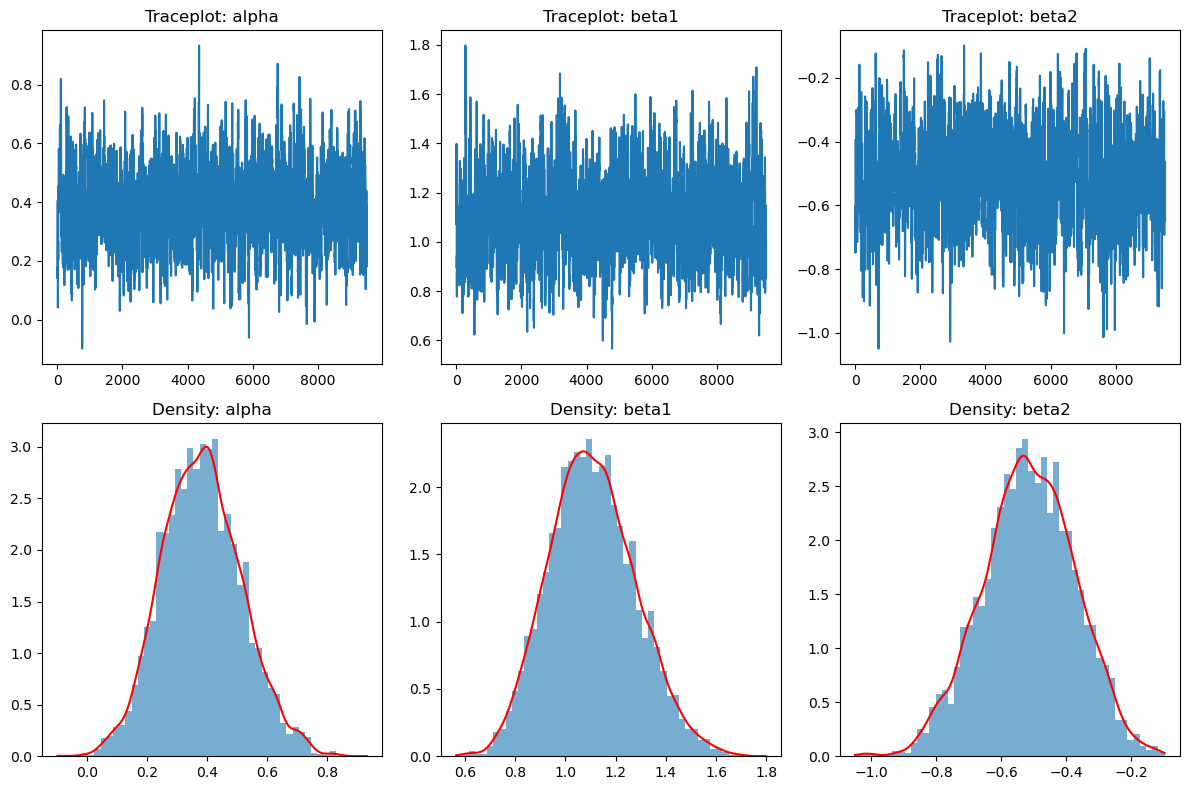

  Parameter    Median        SD
0     alpha  0.381343  0.132908
1     beta1  1.099688  0.172224
2     beta2 -0.514806  0.142406


In [5]:
### Example usage ###
np.random.seed(42)
n = 300
X = np.column_stack((np.ones(n), np.random.normal(size=n), np.random.normal(size=n)))
true_beta = np.array([0.5, 1.2, -0.7])
logit_p = 1 / (1 + np.exp(-(X @ true_beta)))
y = (np.random.uniform(size=n) < logit_p).astype(int)

result = MHflatLogit(nIter=10000, nBurnIn=500, y=y, X=X, delta=0.5, plot=True)
print(result['posteriorSummary'])

### Adding a prior distribution

#### **A Multivariate Normal Prior**

A common choice for the prior on $\beta$ is the multivariate normal (Gaussian) distribution:
$$
\beta \sim \mathcal{N}(\mu_0, \Sigma_0)
$$
where:
- $\mu_0$ is the prior mean vector (typically a vector of zeros for a weakly informative or "neutral" prior).
- $\Sigma_0$ is the prior covariance matrix (often diagonal, with large values for weakly informative priors, or small values for strong regularization).

The density function is:
$$
p(\beta) = \frac{1}{(2\pi)^{p/2} |\Sigma_0|^{1/2}} \exp\left(-\frac{1}{2} (\beta - \mu_0)^\top \Sigma_0^{-1} (\beta - \mu_0)\right)
$$

#### **Role in Posterior Sampling**

In the Metropolis-Hastings algorithm, the prior is combined with the likelihood to determine the posterior (in this case, the unormalized posterior):
$$
p(\beta | \mathbf{y}, X) \propto p(\mathbf{y} | \beta, X) \cdot p(\beta)
$$

This means that higher prior density values for certain $\beta$ make those values more likely to be sampled, all else equal. A normal prior shrinks coefficients toward the prior mean and helps regularize the model, especially when data are sparse or predictors are highly correlated.

In [6]:
def logit_loglik(beta, y, X):
    """
    Computes log-likelihood for a logit model.
    beta: shape (p,) or (n,p)
    y: binary response, shape (n,)
    X: design matrix, shape (n,p)
    Returns: log-likelihood
    """
    beta = np.atleast_2d(beta)
    n = beta.shape[0]
    pll = np.zeros(n)
    for i in range(n):
        eta = X @ beta[i]
        lf1 = np.log(1 / (1 + np.exp(-eta)))
        lf2 = np.log(1 / (1 + np.exp(eta)))
        pll[i] = np.sum(y * lf1 + (1 - y) * lf2)
    return pll if n > 1 else pll[0]

def MHLogitNormalPrior(nIter, nBurnIn, y, X, delta, prior_mean, prior_cov, plot=True):
    """
    Metropolis-Hastings for logistic regression with multivariate normal prior.
    prior_mean: shape (p,)
    prior_cov: shape (p, p)
    """
    if nIter <= nBurnIn:
        raise ValueError("Number of warm-up iterations must be smaller than total iterations.")

    n, p = X.shape

    # Frequentist initialization using statsmodels
    import statsmodels.api as sm
    model = sm.Logit(y, X)
    result = model.fit(disp=0)
    beta_start = result.params
    variance = result.cov_params()

    beta = np.zeros((nIter, p))
    beta[0] = beta_start

    prior_cov_inv = np.linalg.inv(prior_cov)

    for i in range(1, nIter):
        beta_hat = multivariate_normal.rvs(mean=beta[i-1], cov=delta * variance)
        # Log-prior (multivariate normal)
        log_prior_hat = multivariate_normal.logpdf(beta_hat, mean=prior_mean, cov=prior_cov)
        log_prior_prev = multivariate_normal.logpdf(beta[i-1], mean=prior_mean, cov=prior_cov)
        # Log acceptance ratio (posterior is proportional to likelihood * prior)
        logR = (
            logit_loglik(beta_hat, y, X) + log_prior_hat
            - logit_loglik(beta[i-1], y, X) - log_prior_prev
        )
        if np.random.uniform() <= np.exp(logR):
            beta[i] = beta_hat
        else:
            beta[i] = beta[i-1]

    # Remove warm-up iterations
    beta_post = beta[nBurnIn:]

    # Plotting
    if plot:
        fig, axs = plt.subplots(2, p, figsize=(4*p, 8))
        # Traceplots
        for j in range(p):
            axs[0, j].plot(beta_post[:, j])
            axs[0, j].set_title(f'Traceplot: beta{j}' if j > 0 else 'Traceplot: alpha')
        # Density plots
        for j in range(p):
            axs[1, j].hist(beta_post[:, j], bins=50, density=True, alpha=0.6)
            kde = gaussian_kde(beta_post[:, j])
            x_vals = np.linspace(np.min(beta_post[:, j]), np.max(beta_post[:, j]), 200)
            axs[1, j].plot(x_vals, kde(x_vals), 'r')
            axs[1, j].set_title(f'Density: beta{j}' if j > 0 else 'Density: alpha')
        plt.tight_layout()
        plt.show()

    # Posterior summaries
    param_names = [f'alpha'] + [f'beta{j}' for j in range(1, p)]
    summary = pd.DataFrame({
        'Parameter': param_names,
        'Median': np.median(beta_post, axis=0),
        'SD': np.std(beta_post, axis=0)
    })

    # Set column names
    beta_post_df = pd.DataFrame(beta_post, columns=param_names)

    output = {
        'posteriorSummary': summary,
        'posteriorSamples': beta_post_df
    }
    return output

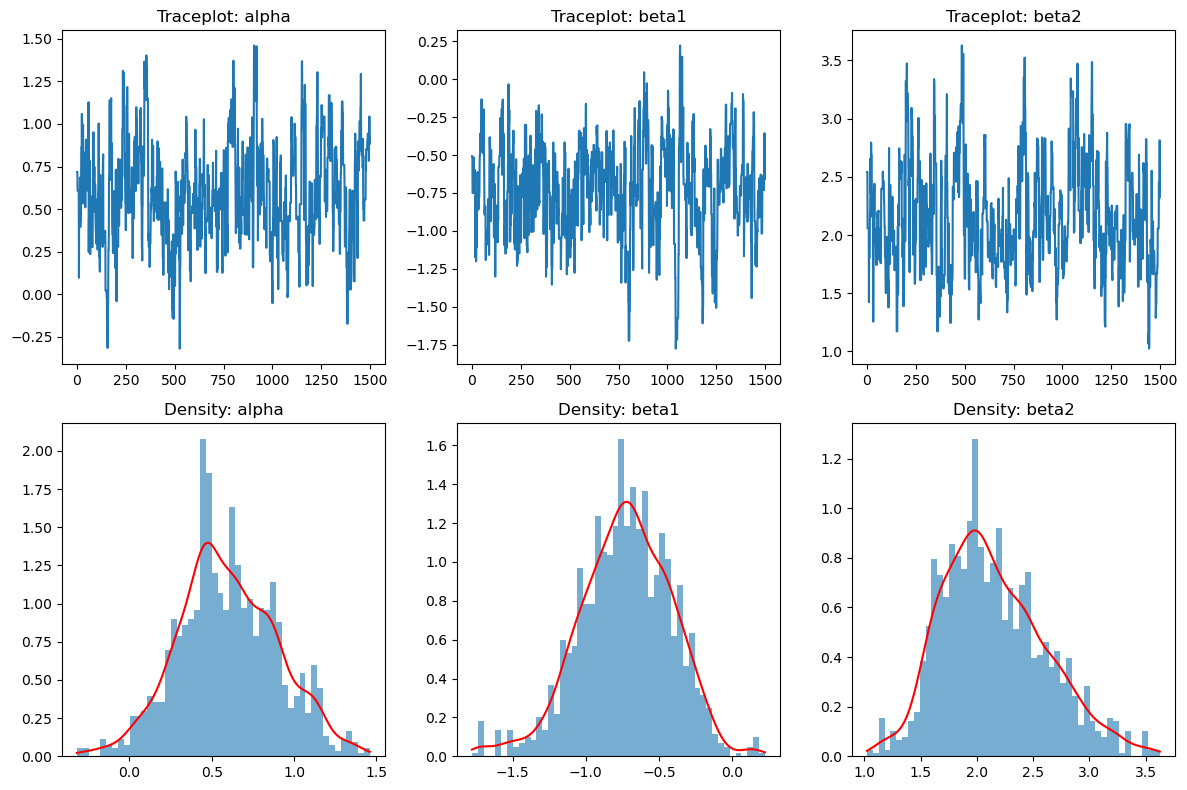

  Parameter    Median        SD
0     alpha  0.584142  0.301173
1     beta1 -0.719400  0.312752
2     beta2  2.085825  0.460310


In [7]:
# Example usage

## Simulate data
n = 100
p = 3
np.random.seed(0)
X = np.hstack((np.ones((n, 1)), np.random.randn(n, p - 1)))  # intercept + two predictors
beta_true = np.array([0.5, -1.0, 2.0])
eta = X @ beta_true
prob = 1 / (1 + np.exp(-eta))
y = np.random.binomial(1, prob, size=n)

## Prior: mean 0, covariance diag(10^2) - this is a non-informative prior (mean 0 and high variance)
prior_mean = np.zeros(p)
prior_cov = np.eye(p) * 100

### Run the sampler ###
output = MHLogitNormalPrior(
    nIter = 10000,         # total iterations
    nBurnIn = 5000,        # burn-in
    y = y,
    X = X,
    delta = 1.0,          # proposal scale
    prior_mean = prior_mean,
    prior_cov = prior_cov,
    plot = True           # show trace and density plots
)

print(output['posteriorSummary'])